## Lec 5. 扩散模型 Diffusion & U-Net

- 生成式模型 Generative Model
    - 文本生成: ChatGPT (GPT, Generative Pre-trained Transformer), DeepSeek, 循环神经网络 (RNN)
    - 图像生成: 生成对抗网络 (GAN, Generative Adversarial Networks), 扩散模型 `Diffusion`
    - 语音生成：......
    - 视频生成：......
- 扩散模型 Diffusion
    - `U-Net`
        - 下采样
        - 上采样
    - VAE (变分自编码器)
    - CLIP 

In [1]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

In [3]:
# 1. 构建数据集
dataset = torchvision.datasets.MNIST(root="mnist/", 
                                     train=True, 
                                     download=True, 
                                     transform=torchvision.transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [4]:
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

In [5]:
torchvision.utils.make_grid(x).shape

torch.Size([3, 32, 242])

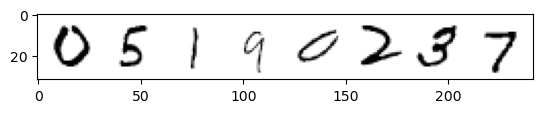

In [6]:
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [7]:
# 2. 添加噪声
def corrupt(x, amount):
    """ 给图像添加噪声的函数 """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return (1-amount)*x + amount*noise

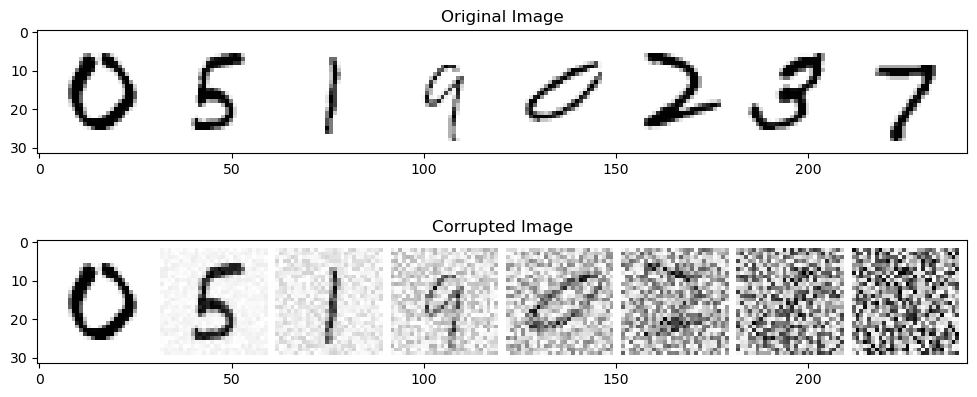

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Original Image")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)
axs[1].set_title("Corrupted Image")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [9]:
# 3. 构建模型
class BasicUNet(nn.Module):
    """ 基础U-Net模型 """
    def __init__(self, in_channels=1, out_channels=1):
        """ 构造方法 """
        super().__init__()
        # 下采样 - 通道数增多, 特征图缩小 (通过原始图像，抽取图像特征)
        self.down_layers = nn.ModuleList([nn.Conv2d(in_channels, 32, kernel_size=5, padding=2), 
                                          nn.Conv2d(32, 64, kernel_size=5, padding=2), 
                                          nn.Conv2d(64, 64, kernel_size=5, padding=2)])

        # 上采样 - 通道数减少，特征图放大 (通过图像特征，重新塑造新的图像)
        self.up_layers = nn.ModuleList([nn.Conv2d(64, 64, kernel_size=5, padding=2), 
                                        nn.Conv2d(64, 32, kernel_size=5, padding=2), 
                                        nn.Conv2d(32, out_channels, kernel_size=5, padding=2)])

        self.activation = nn.ReLU()
        self.downscale = nn.MaxPool2d(kernel_size=2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        """ 前向传播方法 """
        hidden = []  # 存储下采样流程中的中间结果 [特征图]
        # 下采样流程
        for idx, layer in enumerate(self.down_layers):
            x = self.activation(layer(x))
            if idx<2:
                hidden.append(x)
                x = self.downscale(x)

        # 上采样流程
        for idx, layer in enumerate(self.up_layers):
            if idx>0:
                x = self.upscale(x)
                x = x + hidden.pop()
            x = self.activation(layer(x))
        return x

In [10]:
model = BasicUNet()
model

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (activation): ReLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)

In [11]:
x = torch.rand(16, 1, 28, 28)
y_hat = model(x)
y_hat.shape

torch.Size([16, 1, 28, 28])

In [12]:
# 4. 训练模型
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
model = BasicUNet().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [13]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    total_loss = 0.0
    for x, _ in dataloader:
        x = x.to(device)
        amount = torch.rand(x.shape[0]).to(device)
        noised_x = corrupt(x, amount)
        y_hat = model(noised_x)
        loss = loss_func(y_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Loss: {total_loss/len(dataloader): 0.5f}")
    return total_loss/len(dataloader)

Loss:  0.09090
Loss:  0.07159
Loss:  0.05705
Loss:  0.04542
Loss:  0.03902
Loss:  0.03499
Loss:  0.03253
Loss:  0.03075
Loss:  0.02962
Loss:  0.02845


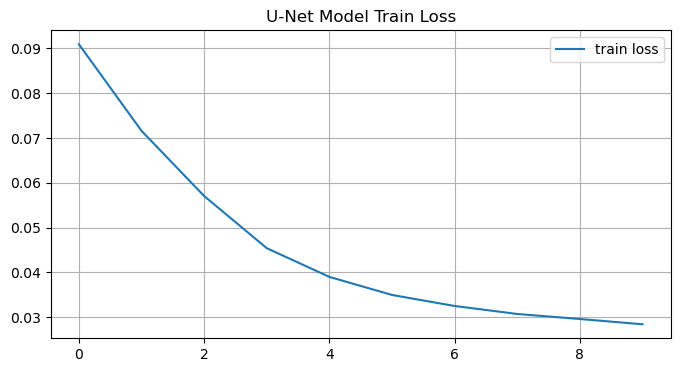

In [14]:
n_epoch = 10
train_loss = []

for i in range(n_epoch):
    loss = train_model(model, train_dataloader, loss_func, optimizer)
    train_loss.append(loss)

import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label="train loss")
plt.title("U-Net Model Train Loss")
plt.legend()

plt.grid()
plt.show()

In [15]:
# 5. 模型推理
x, y = next(iter(train_dataloader))
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    y_hat = model(noised_x.to(device)).detach().cpu()

In [16]:
y_hat.shape

torch.Size([8, 1, 28, 28])

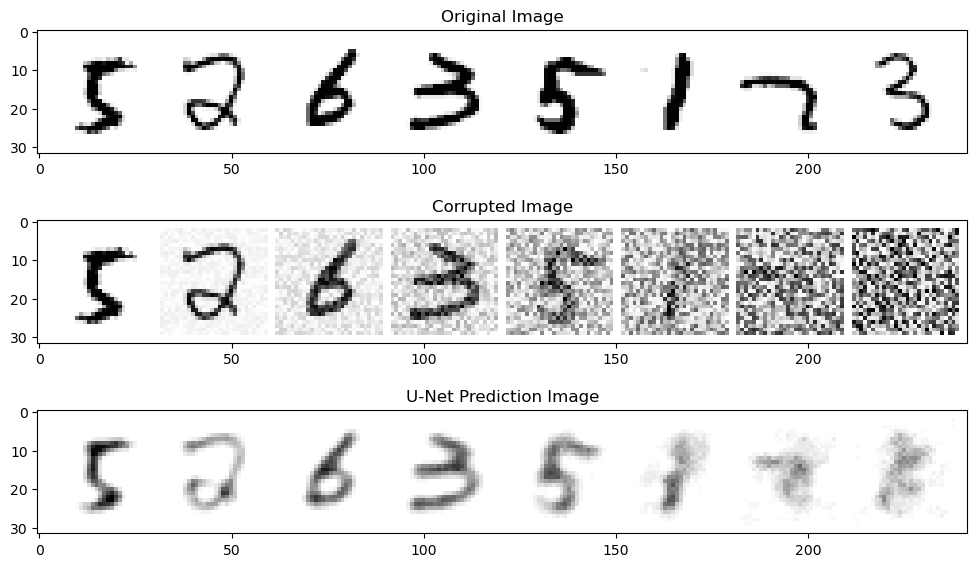

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Original Image")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

axs[1].set_title("Corrupted Image")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

axs[2].set_title("U-Net Prediction Image")
axs[2].imshow(torchvision.utils.make_grid(y_hat)[0], cmap="Greys")